In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import scipy.stats as stats
from sklearn.tree import DecisionTreeRegressor

In [5]:
raw_data = pd.read_csv("test_scores.csv",)
raw_data.head()

,school,school_setting,school_type,classroom,teaching_method,n_student,student_id,gender,lunch,pretest,posttest
0,ANKYI,Urban,Non-public,6OL,Standard,20.0,2FHT3,Female,Does not qualify,62.0,72.0
1,ANKYI,Urban,Non-public,6OL,Standard,20.0,3JIVH,Female,Does not qualify,66.0,79.0
2,ANKYI,Urban,Non-public,6OL,Standard,20.0,3XOWE,Male,Does not qualify,64.0,76.0
3,ANKYI,Urban,Non-public,6OL,Standard,20.0,556O0,Female,Does not qualify,61.0,77.0
4,ANKYI,Urban,Non-public,6OL,Standard,20.0,74LOE,Male,Does not qualify,64.0,76.0


In [6]:
f_data = raw_data.loc[:,~raw_data.columns.isin({"school","classroom","student_id"})].copy()
f_data.head()

,school_setting,school_type,teaching_method,n_student,gender,lunch,pretest,posttest
0,Urban,Non-public,Standard,20.0,Female,Does not qualify,62.0,72.0
1,Urban,Non-public,Standard,20.0,Female,Does not qualify,66.0,79.0
2,Urban,Non-public,Standard,20.0,Male,Does not qualify,64.0,76.0
3,Urban,Non-public,Standard,20.0,Female,Does not qualify,61.0,77.0
4,Urban,Non-public,Standard,20.0,Male,Does not qualify,64.0,76.0


In [7]:
for col in f_data.columns:
    if (f_data[col].dtype == "object"):
        f_data[col] = f_data[col].astype('category')


In [8]:
f_data.posttest.describe().to_frame()


,posttest
count,2133.000000
mean,67.102203
std,13.986789
min,32.000000
25%,56.000000
50%,68.000000
75%,77.000000
max,100.000000


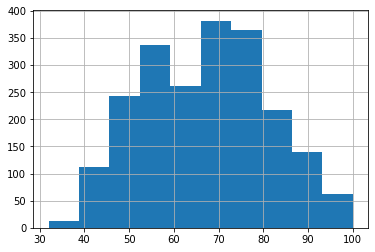

In [9]:
f_data.posttest.hist()
plt.show()

In [10]:
f_data["binned_grades"] = pd.cut(f_data.posttest, bins=10)
(pd.crosstab(f_data.binned_grades,f_data.school_type,normalize="columns")*100).round(1)

school_type,Non-public,Public
binned_grades,,
"(31.932, 38.8]",0.0,0.8
"(38.8, 45.6]",0.2,7.0
"(45.6, 52.4]",3.3,14.3
"(52.4, 59.2]",6.5,19.1
"(59.2, 66.0]",4.5,17.3
"(66.0, 72.8]",15.8,16.3
"(72.8, 79.6]",31.4,12.1
"(79.6, 86.4]",26.1,4.7
"(86.4, 93.2]",7.8,6.1


In [11]:
data = f_data.copy()
categories = dict()
for col in data.columns:
    if str(data[col].dtype) != "category":
        continue
    if len(cats := data[col].cat.categories) == 2:
        categories[col] = {cats[0]:-1,cats[1]:1}
    else:
        categories[col] = {cats[i]:i for i in range(len(cats))}
    data[col] = data[col].apply(lambda x: categories[col][x])
print(categories)
data.head()

{'school_setting': {'Rural': 0, 'Suburban': 1, 'Urban': 2}, 'school_type': {'Non-public': -1, 'Public': 1}, 'teaching_method': {'Experimental': -1, 'Standard': 1}, 'gender': {'Female': -1, 'Male': 1}, 'lunch': {'Does not qualify': -1, 'Qualifies for reduced/free lunch': 1}, 'binned_grades': {Interval(31.932, 38.8, closed='right'): 0, Interval(38.8, 45.6, closed='right'): 1, Interval(45.6, 52.4, closed='right'): 2, Interval(52.4, 59.2, closed='right'): 3, Interval(59.2, 66.0, closed='right'): 4, Interval(66.0, 72.8, closed='right'): 5, Interval(72.8, 79.6, closed='right'): 6, Interval(79.6, 86.4, closed='right'): 7, Interval(86.4, 93.2, closed='right'): 8, Interval(93.2, 100.0, closed='right'): 9}}


,school_setting,school_type,teaching_method,n_student,gender,lunch,pretest,posttest,binned_grades
0,2,-1,1,20.0,-1,-1,62.0,72.0,5
1,2,-1,1,20.0,-1,-1,66.0,79.0,6
2,2,-1,1,20.0,1,-1,64.0,76.0,6
3,2,-1,1,20.0,-1,-1,61.0,77.0,6
4,2,-1,1,20.0,1,-1,64.0,76.0,6


In [12]:
data

,school_setting,school_type,teaching_method,n_student,gender,lunch,pretest,posttest,binned_grades
0,2,-1,1,20.0,-1,-1,62.0,72.0,5
1,2,-1,1,20.0,-1,-1,66.0,79.0,6
2,2,-1,1,20.0,1,-1,64.0,76.0,6
3,2,-1,1,20.0,-1,-1,61.0,77.0,6
4,2,-1,1,20.0,1,-1,64.0,76.0,6
...,...,...,...,...,...,...,...,...,...
2128,2,1,1,30.0,-1,-1,39.0,55.0,3
2129,2,1,1,30.0,-1,1,38.0,46.0,2
2130,2,1,1,30.0,-1,1,45.0,51.0,2
2131,2,1,1,30.0,1,1,46.0,53.0,3


In [13]:

r_data = data.sample(frac=1, random_state=13077, ignore_index=True).drop(columns=["pretest","binned_grades"])
# Separa o df em train e test, com teste de 1/3
train, test =(r_data.iloc[:1000].copy(), r_data.iloc[1000:].copy())
tree = DecisionTreeRegressor()
tree.fit(train.drop(columns=["posttest"]),train.posttest)
test["prediction"] = tree.predict(test.drop(columns=["posttest"]))
test.head()

TypeError: sample() got an unexpected keyword argument 'ignore_index'

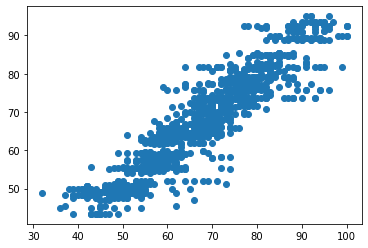

In [ ]:
plt.scatter(test.posttest,test.prediction)